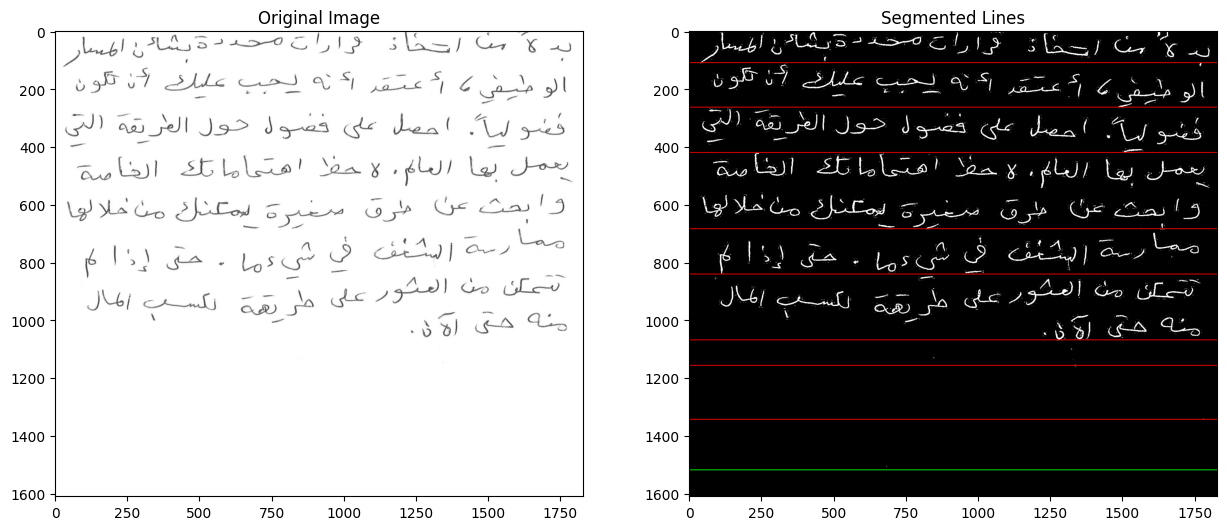

In [12]:
import numpy as np
import cv2
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import os

def adaptive_threshold(image):
    # Apply adaptive thresholding
    binary = cv2.adaptiveThreshold(
        image, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        blockSize=15,
        C=5
    )
    # Ensure strictly binary values (0 or 255)
    _, binary = cv2.threshold(binary, 127, 255, cv2.THRESH_BINARY)
    return binary

def align_text(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        merged_contour = np.concatenate(contours)
        rect = cv2.minAreaRect(merged_contour)
        angle = rect[-1]

        # Correct angle calculation for text orientation
        if angle > 45:
            angle = angle - 90
        elif angle < -45:
            angle = 90 + angle

        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        _, rotated = cv2.threshold(rotated, 127, 255, cv2.THRESH_BINARY)
        return rotated
    return image

def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    binary = adaptive_threshold(img)
    aligned = align_text(binary)
    kernel = np.ones((2,2), np.uint8)
    cleaned = cv2.morphologyEx(aligned, cv2.MORPH_CLOSE, kernel)
    # Final binary check
    _, cleaned = cv2.threshold(cleaned, 127, 255, cv2.THRESH_BINARY)
    return cleaned, img

def compute_horizontal_projection(binary_image):
    return np.sum(binary_image, axis=1)

def segment_lines(binary_image):
    h_projection = compute_horizontal_projection(binary_image)
    peaks, _ = find_peaks(-h_projection, distance=50)

    peak_values = h_projection[peaks]
    sorted_indices = np.argsort(peak_values)
    significant_peaks = peaks[sorted_indices[:len(peaks)//2]]
    significant_peaks.sort()

    line_boundaries = []
    for i in range(len(significant_peaks)-1):
        start = significant_peaks[i]
        end = significant_peaks[i+1]
        line_boundaries.append((start, end))

    return line_boundaries

def extract_and_save_lines(original_image, binary_image, line_boundaries, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    saved_lines = []
    for i, (start, end) in enumerate(line_boundaries):
        line_orig = original_image[start:end, :]
        line_bin = binary_image[start:end, :]

        orig_path = os.path.join(output_dir, f'line_{i+1}_original.png')
        bin_path = os.path.join(output_dir, f'line_{i+1}_binary.png')

        cv2.imwrite(orig_path, line_orig)
        cv2.imwrite(bin_path, line_bin)
        saved_lines.append((orig_path, bin_path))

    return saved_lines

def main(image_path, output_dir):
    binary, original = preprocess_image(image_path)
    line_boundaries = segment_lines(binary)
    saved_lines = extract_and_save_lines(original, binary, line_boundaries, output_dir)

    result = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
    for start, end in line_boundaries:
        cv2.line(result, (0, start), (result.shape[1], start), (0, 0, 255), 2)
        cv2.line(result, (0, end), (result.shape[1], end), (0, 255, 0), 2)

    plt.figure(figsize=(15, 10))
    plt.subplot(121), plt.imshow(original, cmap='gray')
    plt.title('Original Image')
    plt.subplot(122), plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title('Segmented Lines')
    plt.show()

    return saved_lines, result

# Usage example:
saved_lines, result = main('/content/004_user004_paragraph_2_001.png', 'output_lines5')